In [1]:
import os
import json
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Directory containing the JSON files
DATA_DIRECTORY = Path.home() / 'Downloads' / 'zyte_data'

# Lists to store parsed data
vehicles_data = []
arrivals_data = []

# Load JSON data into DataFrames
for json_file in DATA_DIRECTORY.glob("*.json"):
    with open(json_file, 'r') as file:
        try:
            json_content = json.load(file)
            data_entry = json_content[0]  # Each file contains a list with one dict

            # Process 'vehicles' data
            vehicles = data_entry.get("vehicles", [])
            for vehicle in vehicles:
                vehicle_data = {
                    "timestamp": datetime.fromtimestamp(vehicle.get("timestamp", 0) / 1000),
                    "vehicle_id": vehicle.get("id"),
                    "route_id": vehicle.get("route_id"),
                    "trip_id": vehicle.get("trip_id"),
                    "position_lat": vehicle.get("position", [None, None])[0],
                    "position_lon": vehicle.get("position", [None, None])[1],
                    "speed": vehicle.get("speed"),
                    "heading": vehicle.get("heading"),
                    "arrival_status": vehicle.get("arrival_status"),
                    "service_status": vehicle.get("service_status"),
                    "current_stop_id": vehicle.get("current_stop_id"),
                    "next_stop": vehicle.get("next_stop"),
                    "off_route": vehicle.get("off_route"),
                    "load": vehicle.get("load"),
                }
                vehicles_data.append(vehicle_data)

            # Process 'arrivals' data
            arrivals = data_entry.get("arrivals", [])
            for arrival in arrivals:
                arrival_data = {
                    "timestamp": datetime.fromtimestamp(arrival.get("timestamp", 0)),
                    "vehicle_id": arrival.get("vehicle_id"),
                    "route_id": arrival.get("route_id"),
                    "stop_id": arrival.get("stop_id"),
                    "trip_id": arrival.get("trip_id"),
                    "distance": arrival.get("distance"),
                    "type": arrival.get("type"),
                    "headsign": arrival.get("headsign"),
                }
                arrivals_data.append(arrival_data)

        except json.JSONDecodeError:
            print(f"Failed to decode {json_file}")

# Convert to DataFrames
vehicles_df = pd.DataFrame(vehicles_data)
arrivals_df = pd.DataFrame(arrivals_data)

# Optional: Save DataFrames to CSV
# vehicles_df.to_csv(DATA_DIRECTORY / "vehicles_data.csv", index=False)
# arrivals_df.to_csv(DATA_DIRECTORY / "arrivals_data.csv", index=False)


In [2]:
# Define the mapping of route_id to bus type
route_id_to_bus_type = {
    4014238: '1BU',
    4016220: 'Fenway',
    4017436: 'Comm Ave'
    # Ignoring 4017474 (Hyatt bus)
}

# Scheduled times for 1BU bus at Agganis Way
scheduled_times_1BU = [
    '06:00', '06:30', '07:00', '07:10', '07:20', '07:30', '07:40', '07:50',
    '08:00', '08:10', '08:20', '08:30', '08:40', '08:50', '09:00', '09:10',
    '09:20', '09:30', '09:40', '09:50', '10:00', '10:20', '10:40', '11:00',
    '11:20', '11:40', '12:00', '12:20', '12:40', '13:00', '13:20', '13:40',
    '14:00', '14:20', '14:40', '15:00', '15:20', '15:40', '16:00', '16:10',
    '16:20', '16:30', '16:40', '16:50', '17:00', '17:10', '17:20', '17:30',
    '17:40', '17:50', '18:00', '18:10', '18:20', '18:30', '18:40', '18:50',
    '19:15', '19:30', '19:45', '20:00', '20:20', '20:40', '21:00', '21:20',
    '21:40', '22:00', '22:30', '23:00'
]

# Hypothetical scheduled times for Fenway bus at Agganis Way
scheduled_times_Fenway = [
    '06:15', '06:45', '07:15', '07:45', '08:15', '08:45',
    '09:15', '09:45', '10:15', '10:45', '11:15', '11:45',
    '12:15', '12:45', '13:15', '13:45', '14:15', '14:45',
    '15:15', '15:45', '16:15', '16:45', '17:15', '17:45',
    '18:15', '18:45', '19:15', '19:45', '20:15', '20:45',
    '21:15', '21:45', '22:15', '22:45', '23:15'
]

# Hypothetical scheduled times for Comm Ave bus at Agganis Way
scheduled_times_CommAve = [
    '06:30', '07:00', '07:30', '08:00', '08:30', '09:00',
    '09:30', '10:00', '10:30', '11:00', '11:30', '12:00',
    '12:30', '13:00', '13:30', '14:00', '14:30', '15:00',
    '15:30', '16:00', '16:30', '17:00', '17:30', '18:00',
    '18:30', '19:00', '19:30', '20:00', '20:30', '21:00',
    '21:30', '22:00', '22:30', '23:00'
]

# Dictionary of scheduled times
scheduled_times_dict = {
    '1BU': scheduled_times_1BU,
    'Fenway': scheduled_times_Fenway,
    'Comm Ave': scheduled_times_CommAve
}


In [3]:
# Map 'bus_type' to arrivals_df based on 'route_id'
arrivals_df['bus_type'] = arrivals_df['route_id'].map(route_id_to_bus_type)

# Drop any rows where 'bus_type' is NaN (route_id not in the mapping)
arrivals_df.dropna(subset=['bus_type'], inplace=True)

# Ensure 'route_id' and 'stop_id' are numeric
arrivals_df['route_id'] = pd.to_numeric(arrivals_df['route_id'], errors='coerce')
arrivals_df['stop_id'] = pd.to_numeric(arrivals_df['stop_id'], errors='coerce')

# Remove rows with NaN in 'route_id' or 'stop_id'
arrivals_df.dropna(subset=['route_id', 'stop_id'], inplace=True)


In [16]:
# Assuming 'stop_id_agganis' is specific for each bus
stop_id_agganis_dict = {
    '1BU': 4284294,
    'Fenway': 4284294,  
    'Comm Ave': 4284294 
}

# Create an empty list to collect data for all buses
all_buses_merged = []

for bus_type in ['1BU', 'Fenway', 'Comm Ave']:
    print(f"Processing data for {bus_type} bus...")
    # Get the route_id for this bus type
    route_id = [key for key, value in route_id_to_bus_type.items() if value == bus_type][0]
    
    # Get the stop_id for this bus type
    stop_id_agganis = stop_id_agganis_dict[bus_type]
    
    # Filter arrivals data for this bus type at Agganis Way
    arrivals_bus = arrivals_df[
        (arrivals_df['route_id'] == route_id) &
        (arrivals_df['stop_id'] == stop_id_agganis)
    ].copy()
    
    # Check if arrivals_bus is empty
    if arrivals_bus.empty:
        print(f"No arrivals data for {bus_type} bus at stop {stop_id_agganis}. Skipping.")
        continue
    
    # Convert 'timestamp' to datetime
    arrivals_bus['timestamp'] = pd.to_datetime(arrivals_bus['timestamp'], errors='coerce')
    
    # Remove rows with invalid 'timestamp'
    arrivals_bus.dropna(subset=['timestamp'], inplace=True)
    
    # Extract the date for each arrival
    arrivals_bus['date'] = arrivals_bus['timestamp'].dt.date
    
    # Prepare scheduled times for this bus type
    scheduled_times = scheduled_times_dict[bus_type]
    scheduled_arrivals = [datetime.strptime(time_str, '%H:%M').time() for time_str in scheduled_times]
    
    # Map scheduled times to dates
    if arrivals_bus['date'].empty:
        print(f"No dates found for {bus_type} bus in arrivals data. Skipping.")
        continue
    
    scheduled_rows = [
        {'date': date, 'scheduled_time': datetime.combine(date, time)}
        for date in arrivals_bus['date'].unique()
        for time in scheduled_arrivals
    ]
    
    scheduled_df = pd.DataFrame(scheduled_rows)
    
    # Check if scheduled_df is empty
    if scheduled_df.empty:
        print(f"No scheduled times data for {bus_type} bus on dates present in arrivals. Skipping.")
        continue
    
    # Convert 'scheduled_time' to datetime
    scheduled_df['scheduled_time'] = pd.to_datetime(scheduled_df['scheduled_time'], errors='coerce')
    scheduled_df.dropna(subset=['scheduled_time'], inplace=True)
    
    # Sort both DataFrames by their respective time columns
    arrivals_bus_sorted = arrivals_bus.sort_values('timestamp')
    scheduled_df_sorted = scheduled_df.sort_values('scheduled_time')
    
    # Perform the merge_asof
    merged_df = pd.merge_asof(
        arrivals_bus_sorted,
        scheduled_df_sorted,
        left_on='timestamp',
        right_on='scheduled_time',
        direction='nearest',
        tolerance=pd.Timedelta('30m')  # Allow a 30-minute window for matching
    )
    
    # Drop rows with NaN scheduled times
    merged_df.dropna(subset=['scheduled_time', 'timestamp'], inplace=True)
    
    # Calculate delay (actual - scheduled)
    merged_df['delay'] = (merged_df['timestamp'] - merged_df['scheduled_time']).dt.total_seconds() / 60  # Delay in minutes
    
    # Ensure 'delay' is numeric
    merged_df['delay'] = pd.to_numeric(merged_df['delay'], errors='coerce')
    merged_df.dropna(subset=['delay'], inplace=True)
    
    # Add 'bus_type' to merged_df
    merged_df['bus_type'] = bus_type
    
    # Append to the list
    all_buses_merged.append(merged_df)


Processing data for 1BU bus...
Processing data for Fenway bus...
Processing data for Comm Ave bus...
No arrivals data for Comm Ave bus at stop 4284294. Skipping.


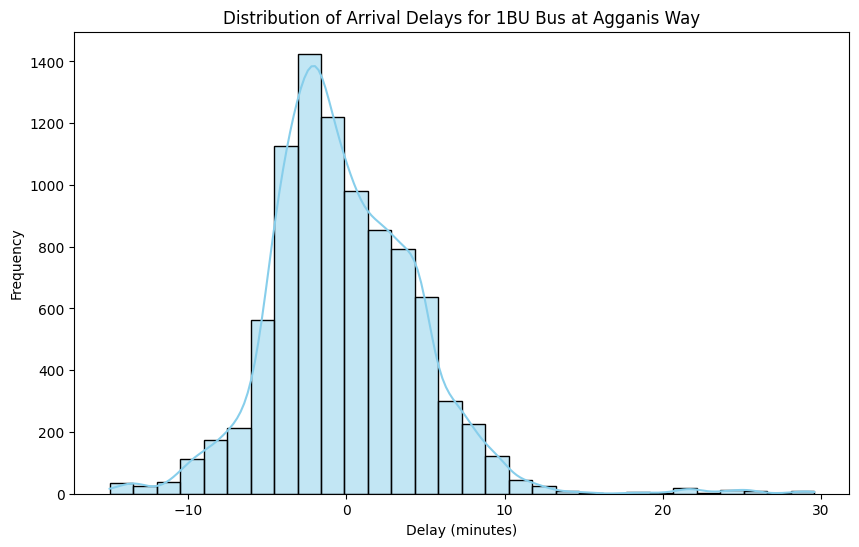

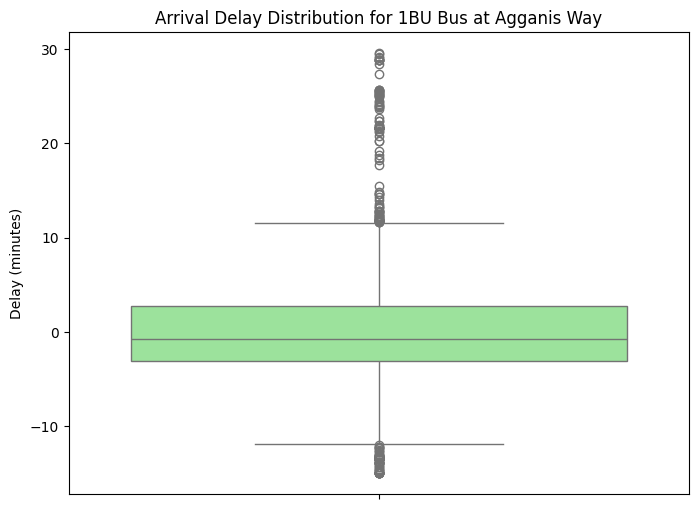

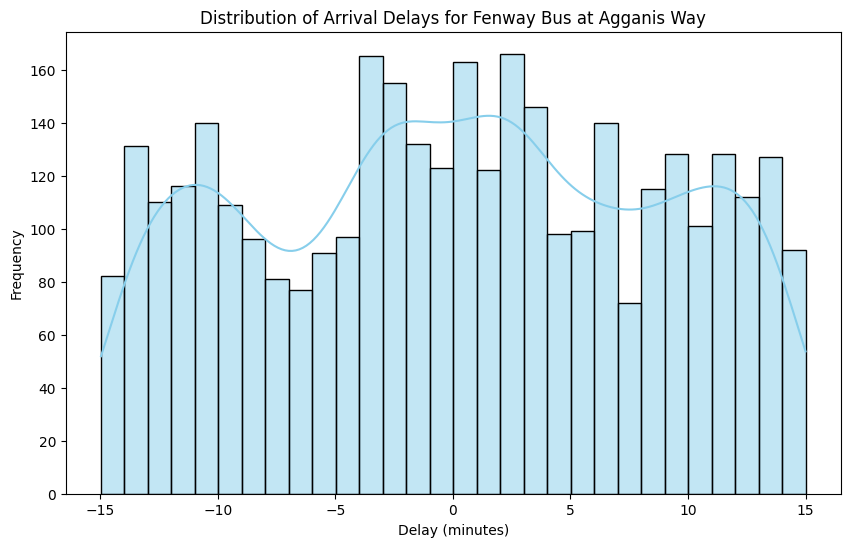

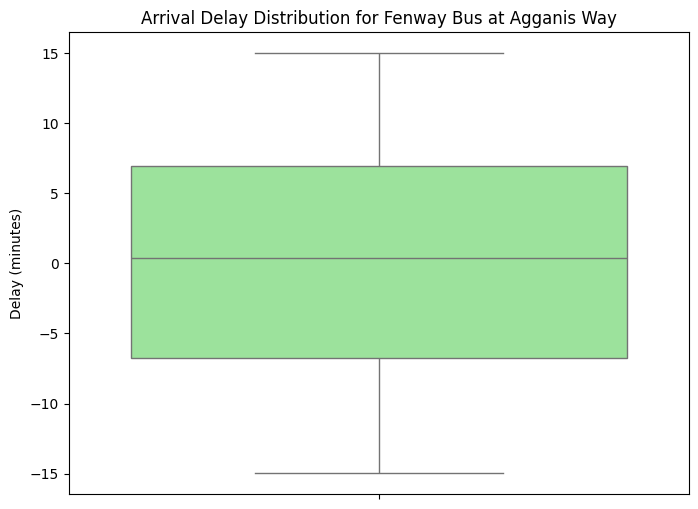

In [22]:
for bus_type, merged_df in zip(['1BU', 'Fenway', 'Comm Ave'], all_buses_merged):
    # Histogram of delays for this bus type
    plt.figure(figsize=(10, 6))
    sns.histplot(data=merged_df, x='delay', bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution of Arrival Delays for {bus_type} Bus at Agganis Way')
    plt.xlabel('Delay (minutes)')
    plt.ylabel('Frequency')
    plt.show()
    
    # Box plot of delays for this bus type
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=merged_df, y='delay', color='lightgreen')
    plt.title(f'Arrival Delay Distribution for {bus_type} Bus at Agganis Way')
    plt.ylabel('Delay (minutes)')
    plt.show()

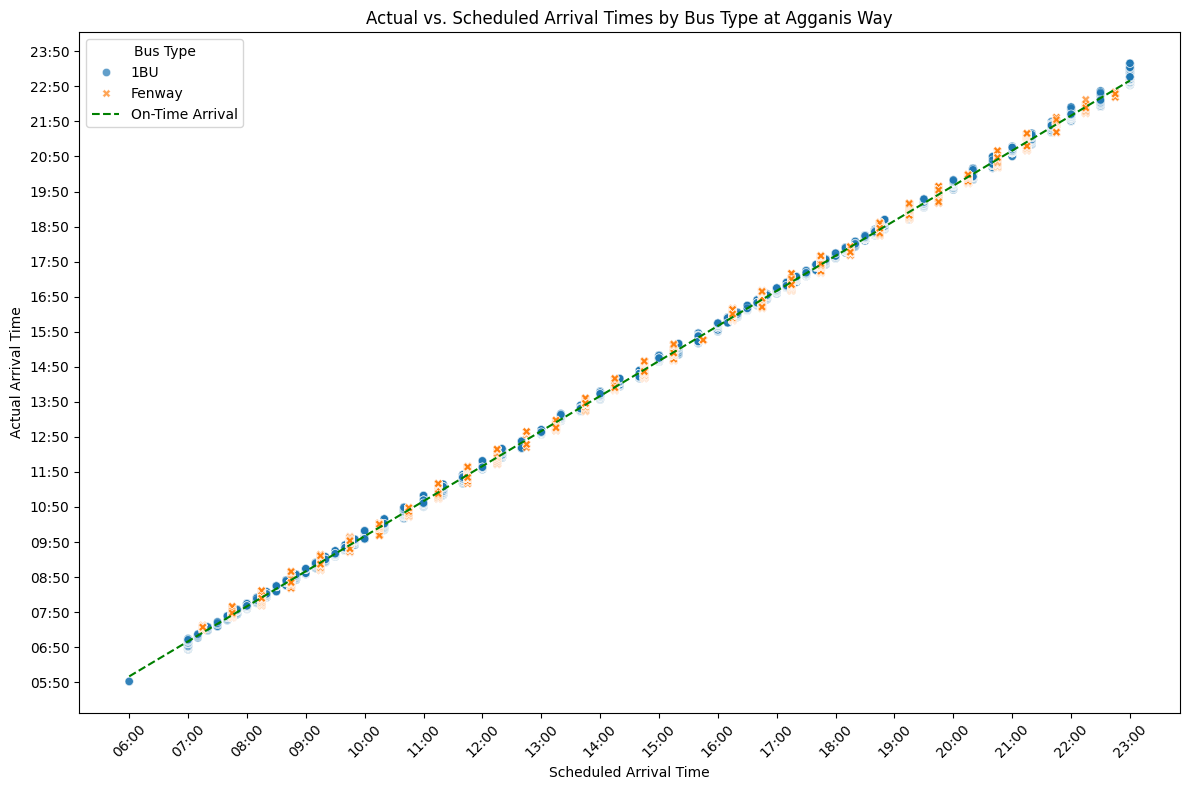

In [18]:
# Convert minutes back to time format for readability
def minutes_to_time_label(minutes):
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    return f"{hours:02d}:{mins:02d}"

# Update scatter plot with time labels
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=combined_merged_df,
    x='scheduled_minutes',
    y='actual_minutes',
    hue='bus_type',
    style='bus_type',
    alpha=0.7
)

# Set x and y ticks
x_ticks = range(int(combined_merged_df['scheduled_minutes'].min()), int(combined_merged_df['scheduled_minutes'].max()) + 60, 60)
y_ticks = range(int(combined_merged_df['actual_minutes'].min()), int(combined_merged_df['actual_minutes'].max()) + 60, 60)

plt.xticks(ticks=x_ticks, labels=[minutes_to_time_label(tick) for tick in x_ticks], rotation=45)
plt.yticks(ticks=y_ticks, labels=[minutes_to_time_label(tick) for tick in y_ticks])

# Add labels and title
plt.xlabel('Scheduled Arrival Time')
plt.ylabel('Actual Arrival Time')
plt.title('Actual vs. Scheduled Arrival Times by Bus Type at Agganis Way')

# Add reference line where actual time equals scheduled time
plt.plot(
    [combined_merged_df['scheduled_minutes'].min(), combined_merged_df['scheduled_minutes'].max()],
    [combined_merged_df['scheduled_minutes'].min(), combined_merged_df['scheduled_minutes'].max()],
    color='green',
    linestyle='--',
    label='On-Time Arrival'
)

plt.legend(title='Bus Type')
plt.tight_layout()
plt.show()


/var/folders/nr/h__4s02s4xn5w37kwzd9ny0w0000gn/T/ipykernel_27845/3347880753.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_merged_df, x='bus_type', y='delay', palette='Set2')


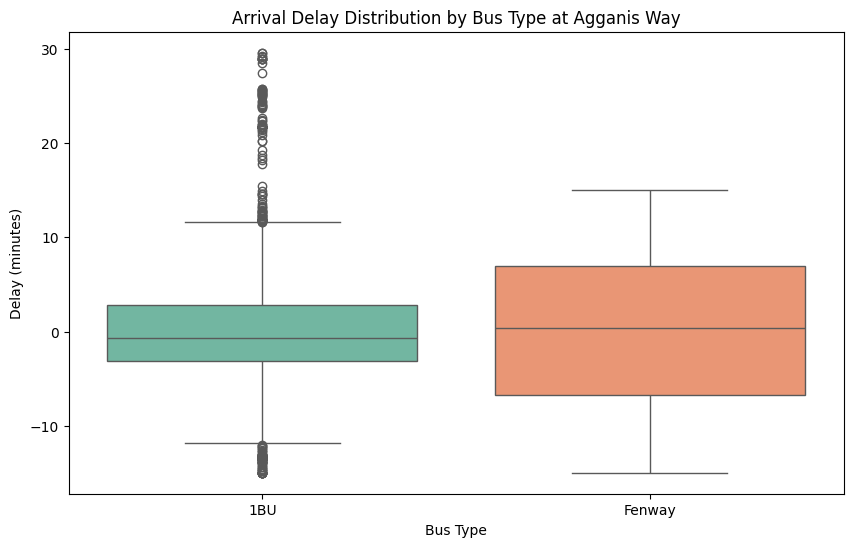

/var/folders/nr/h__4s02s4xn5w37kwzd9ny0w0000gn/T/ipykernel_27845/3347880753.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_delay_bus, x='bus_type', y='delay', palette='Set2')


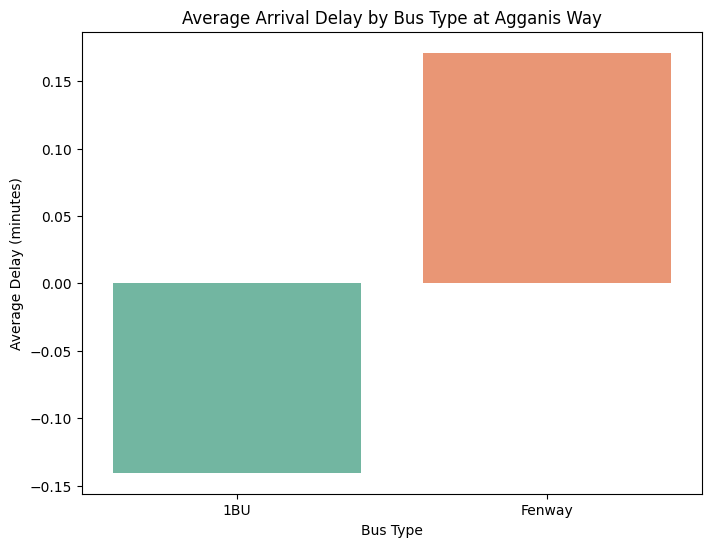

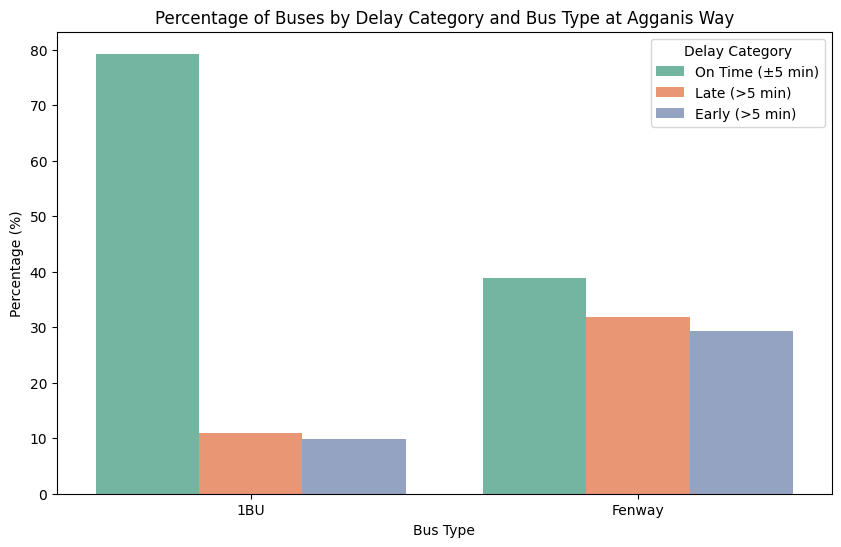

In [12]:
# Box plot of delays by bus type
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_merged_df, x='bus_type', y='delay', palette='Set2')
plt.title('Arrival Delay Distribution by Bus Type at Agganis Way')
plt.xlabel('Bus Type')
plt.ylabel('Delay (minutes)')
plt.show()

# Average delay per bus type
average_delay_bus = combined_merged_df.groupby('bus_type')['delay'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=average_delay_bus, x='bus_type', y='delay', palette='Set2')
plt.title('Average Arrival Delay by Bus Type at Agganis Way')
plt.xlabel('Bus Type')
plt.ylabel('Average Delay (minutes)')
plt.show()

# Percentage of buses by delay category
def categorize_delay(delay):
    if delay <= -5:
        return 'Early (>5 min)'
    elif -5 < delay < 5:
        return 'On Time (±5 min)'
    else:
        return 'Late (>5 min)'

combined_merged_df['delay_category'] = combined_merged_df['delay'].apply(categorize_delay)

# Calculate percentage by bus type
delay_counts = combined_merged_df.groupby('bus_type')['delay_category'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=delay_counts, x='bus_type', y='percentage', hue='delay_category', palette='Set2')
plt.title('Percentage of Buses by Delay Category and Bus Type at Agganis Way')
plt.xlabel('Bus Type')
plt.ylabel('Percentage (%)')
plt.legend(title='Delay Category')
plt.show()


In [14]:
print(combined_merged_df['bus_type'].value_counts())


bus_type
1BU       8984
Fenway    3514
Name: count, dtype: int64
